In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import sqrt
from math import floor

%matplotlib inline 

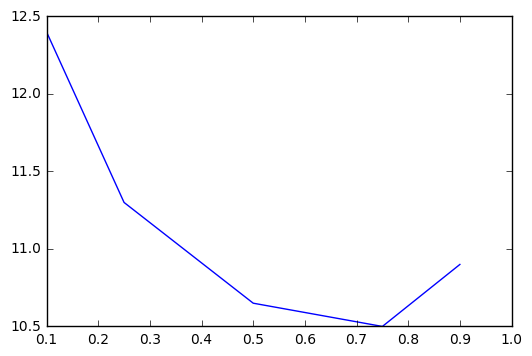

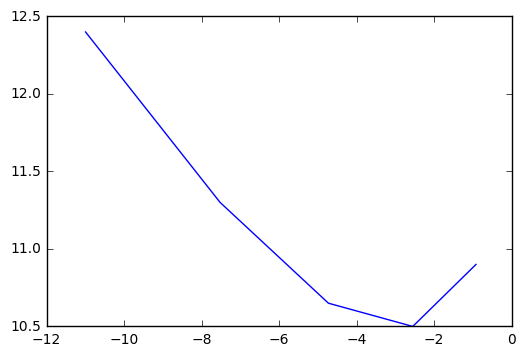

In [87]:
vol = np.array([12.4, 11.3, 10.65, 10.5, 10.9])
delta = np.array([0.1, 0.25, 0.5, 0.75, 0.9])

plt.plot(delta, vol)

t=1.0/12.0
y = vol * sqrt(t)
x = [norm.ppf(delta[i])*y[i]-0.5*y[i]*y[i] for i in range(5)]

plt.figure()
plt.plot(x, vol)

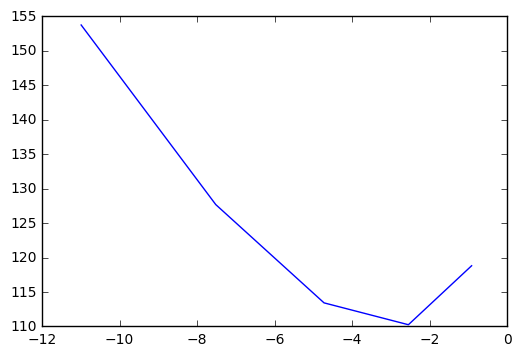

In [88]:
variance = vol**2

plt.plot(x,variance)

In [195]:
class SplineInterpolation:
        def __init__(self, dx, y): # dx is a number, y is a 1d array
            n = len(y)
            if 0 == n % 2:
                raise RuntimeException("must have odd number of y values")

            self._yPoints = y
            self._dx = dx

            self._computeD()
            self._computed()

        def _computeD(self):
            n = len(self._yPoints)

            M = np.zeros((n,n))
            for i in range(1,n-1):
                M[i, i] = 4
                
            for i in range(n-1):
                M[i + 1, i] = 1.0
                M[i, i + 1] = 1.0
            
            M[0, 0] = 2.0
            M[n - 1, n - 1] = 2.0

            M = np.linalg.inv(M)

            Dtmp = np.empty((n, n));
            # first col of D is -ve of first 2 cols of m
            for i in range(n):
                Dtmp[i, 0] = -3 * (M[i, 0] + M[i, 1])
                for j in range(1,n-1):
                    Dtmp[i, j] = 3 * (M[i, j - 1] - M[i, j + 1])
                Dtmp[i, n - 1] = 3 * (M[i, n - 2] + M[i, n - 1])

            self._dydThetaCoefficients = Dtmp
        
        def _computed(self):
            self._dydThetaPoints = np.dot(self._dydThetaCoefficients, self._yPoints)

        def y(self, x): # x is a 1d array
            return np.dot(self._coefficientsY(x),self._yPoints)

        def dydx(self, x): # x is a 1d array
            return np.dot(self._coefficientsDydx(x), self._yPoints)

        def d2ydx2(self, x): # x is a 1d array
            return np.dot(self._coefficientsD2ydx2(x), self._yPoints)

        def L2sqd2ydx2(self):
            a = np.dot(self._yPoints, self._secondDerivSquaredIntegralQuadraticFactor())
            return np.dot(a,a)

            #return np.dot(np.dot(self._yPoints,self._secondDerivSquaredIntegralQuadratic()), self._yPoints)
            
        def _coefficientsY(self, x):
        
            n = len(self._yPoints)
            
            c = np.zeros((len(x), n))
            #for (int i = 0; i != x.Length; ++i)
            for i in range(len(x)):
                
                if x[i]<-self._dx *(n-1)/2:
                    c[i,]=self._coefficientsDydx([x[i]])*(self._dx *((n-1)/2)+x[i])
                    c[i,0]+=1.0
                    
                    #d = self._dx *((n-1)/2)+x[i]
                    #grad = self._coefficientsDydx([x[i]])
                    #grad *= d
                    #grad[0,0] += 1.0
                    #c[i,]=grad
                elif x[i]>self._dx *(n-1)/2:
                    
                    c[i,]=self._coefficientsDydx([x[i]])*(x[i]-self._dx *((n-1)/2))
                    c[i,-1] += 1.0
                    
                    #d = x[i]-self._dx *((n-1)/2)
                    #grad = self._coefficientsDydx([x[i]])
                    #grad *= d
                    #grad[0,-1] += 1.0
                    #c[i,]=grad
                else:

                    _i = int(floor(x[i] / self._dx)) + (n - 1) / 2
                    _i = max(_i, 0);
                    _i = min(_i, n - 2);

                    theta = x[i] / dx - int(floor(x[i] / dx)) # will be between 0 and 1 unless we are extrapolating off an end interval

                    theta2 = theta**2
                    theta3 = theta**3
                    alpha = (1 - 3 * theta2 + 2 * theta3)
                    beta = (3 * theta2 - 2 * theta3)
                    gamma = (theta - 2 * theta2 + theta3)
                    delta = (theta3 - theta2)

                    #for (int j = 0; j != n; ++j)
                    for j in range(n):
                        c[i, j] = gamma * self._dydThetaCoefficients[_i, j] + delta * self._dydThetaCoefficients[_i + 1, j]
                    c[i, _i] += alpha
                    c[i, _i + 1] += beta

            return c
        
        def _coefficientsDydx(self, x):
        
            n = len(self._yPoints)
            
            # first gradient is flat outside the range
            xmax = self._dx * (n-1)/2
            x = np.array([xmax-1e-12*dx if k>=xmax else -xmax if k<-xmax else k for k in x])
        
            c = np.zeros((len(x), n))
            #for (int i = 0; i != x.Length; ++i)
            for i in range(len(x)):
                _i = int(floor(x[i] / self._dx)) + (n - 1) / 2
                _i = max(_i, 0);
                _i = min(_i, n - 2);

                theta = x[i] / dx - int(floor(x[i] / dx)) # will be between 0 and 1 unless we are extrapolating off an end interval

                theta2 = theta * theta;
                alpha = (-6 * theta + 6 * theta2) / dx;
                beta = (6 * theta - 6 * theta2) / dx;
                gamma = (1 - 4 * theta + 3 * theta2) / dx;
                delta = (3 * theta2 - 2 * theta) / dx;

                #for (int j = 0; j != n; ++j)
                for j in range(n):
                    c[i, j] = gamma * self._dydThetaCoefficients[_i, j] + delta * self._dydThetaCoefficients[_i + 1, j]
                c[i, _i] += alpha
                c[i, _i + 1] += beta

            return c
        
        def _coefficientsD2ydx2(self, x):
        
            n = len(self._yPoints)
            
            # 2nd gradient is flat, indeed zero, outside the range
            xmax = self._dx * (n-1)/2
            x = np.array([xmax-1e-12*dx if k>=xmax else -xmax if k<-xmax else k for k in x])
            
            c = np.zeros((len(x), n))
            #for (int i = 0; i != x.Length; ++i)
            for i in range(len(x)):
                _i = int(floor(x[i] / self._dx)) + (n - 1) / 2
                _i = max(_i, 0);
                _i = min(_i, n - 2);

                theta = x[i] / self._dx - int(floor(x[i] / self._dx)) # will be between 0 and 1 unless we are extrapolating off an end interval

                alpha = (-6 + 12 * theta) / self._dx**2;
                beta = (6 - 12 * theta) / self._dx**2;
                gamma = (-4 + 6 * theta) / self._dx**2;
                delta = (6 * theta - 2) / self._dx**2;

                #for (int j = 0; j != n; ++
                for j in range(n):
                    c[i, j] = gamma * self._dydThetaCoefficients[_i, j] + delta * self._dydThetaCoefficients[_i + 1, j]
                c[i, _i] += alpha
                c[i, _i + 1] += beta

            return c
        
        def _secondDerivSquaredIntegralQuadratic(self):
            # computes sqrt(int_-inf^inf(d2ydx2)^2dx)

            n = len(self._yPoints)

            q = np.zeros((n, n));

            #for (int i = 1; i != n; ++i)
            for i in range(1,n):
                a = np.zeros(n)
                b = np.zeros(n)
                #for (int j = 0; j != n; ++j)
                for j in range(n):
                    a[j] = (-4 * self._dydThetaCoefficients[i - 1, j] - 2 * self._dydThetaCoefficients[i, j])
                    b[j] = (6 * self._dydThetaCoefficients[i - 1, j] + 6 * self._dydThetaCoefficients[i, j])

                a[i - 1] -= 6
                a[i] += 6

                b[i - 1] += 12
                b[i] -= 12

                #for (int j = 0; j != n; ++j)
                    #for (int k = j; k != n; ++k)
                for j in range(n):
                    for k in range(j,n):
                        q[j, k] += a[j] * a[k] + (a[j] * b[k] + a[k] * b[j]) / 2.0 + b[j] * b[k] / 3.0
            

            #for (int j = 0; j != n; ++j)
                #for (int k = j; k != n; ++k)
            for j in range(n):
                for k in range(j,n):
                    q[j, k] /= dx * dx * dx
                    q[k, j] = q[j, k]

            return q

        def _secondDerivSquaredIntegralQuadraticFactor(self):
            return np.linalg.cholesky(self._secondDerivSquaredIntegralQuadratic())


Some test to check the behaviour is as expected. HEre we are looking only between the two end knot points. Will need to check the behaviour of extrapolation also....

First check that the interpolated function looks correct

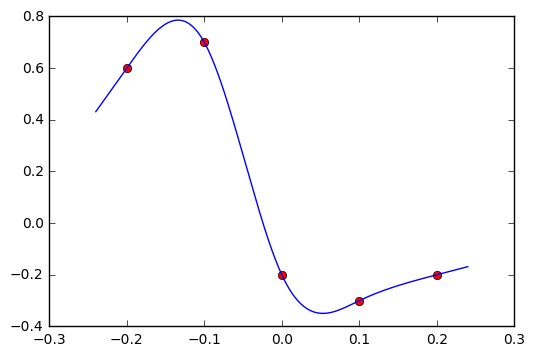

In [196]:

y = [0.6,0.7,-0.2,-0.3,-0.2]
x = [-0.2, -0.1, 0.0, 0.1, 0.2]
dx = 0.1

interp = SplineInterpolation(dx, y)

dx2 = (x[-1]-x[0])/10000
x2 = np.arange(x[0]*1.2, x[-1]*1.2, dx2)
y2 = interp.y(x2)

plt.plot(x,y,'ro')
plt.plot(x2,y2)

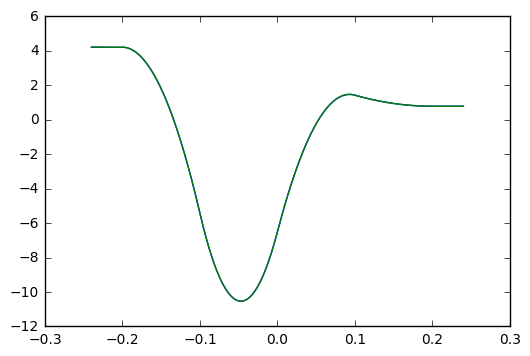

In [197]:
dydx_finite_diff = (y2[2:]-y2[:-2])/(2*dx2)
plt.plot(x2[1:-1],dydx_finite_diff)

dydx = interp.dydx(x2)
plt.plot(x2,dydx)

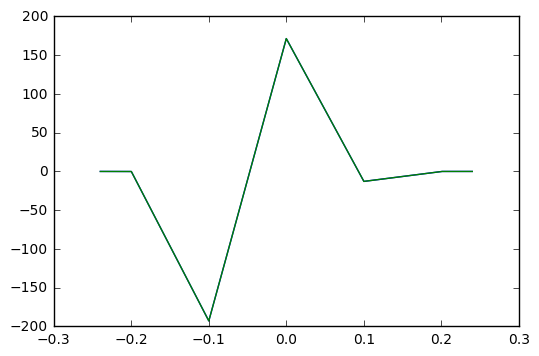

In [198]:
d2ydx2_finite_diff = (y2[2:]+y2[:-2]-2*y2[1:-1])/(dx2**2)
plt.plot(x2[1:-1],d2ydx2_finite_diff)

d2ydx2 = interp.d2ydx2(x2)
plt.plot(x2,d2ydx2)

In [199]:
print(interp.L2sqd2ydx2())
print(np.dot(d2ydx2_finite_diff,d2ydx2_finite_diff)*dx2)

3274.28571429
3274.2851704
